In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

In [73]:
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
import joblib
from scipy.optimize import minimize

In [74]:
folder_path = "/kaggle/input/child-mind-institute-problematic-internet-use"
train_df = pd.read_csv(os.path.join(folder_path, "train.csv"))
test_df = pd.read_csv(os.path.join(folder_path, "test.csv"))
dict_df = pd.read_csv(os.path.join(folder_path, "data_dictionary.csv"))
sample_submission_df = pd.read_csv(os.path.join(folder_path, "sample_submission.csv"))

In [75]:
def table_to_describe_list(dir_name, file_name):
    df = pd.read_parquet(os.path.join(dir_name, file_name, 'part-0.parquet'))
    df.drop("step", axis=1, inplace=True)
    return df.describe().values.reshape(-1), file_name.split('=')[1]

def make_parquet_df(df_name):
    parquet_path = os.path.join(folder_path, "series_{}.parquet".format(df_name))
    ids = os.listdir(parquet_path)
    with ThreadPoolExecutor() as executor:
        describe_list = list(tqdm(executor.map(lambda f_name: table_to_describe_list(parquet_path, f_name), ids), total = len(ids)))
    stats, indexes = zip(*describe_list)
    df = pd.DataFrame(stats, columns = [f'stat_{i}' for i in range(len(stats[0]))])
    df['id'] = indexes
    return df
output_pass = "/kaggle/working"
if not os.path.exists(os.path.join(output_pass, "train_parquet.csv")) or not os.path.exists(os.path.join(output_pass, "test_parquet.csv")):
    train_parquet_df = make_parquet_df('train')   
    test_parquet_df = make_parquet_df("test")
    train_parquet_df.to_csv(os.path.join(output_pass, "train_parquet.csv"), index=False)
    test_parquet_df.to_csv(os.path.join(output_pass, "test_parquet.csv"), index=False)
train_parquet_df = pd.read_csv("train_parquet.csv")
test_parquet_df = pd.read_csv("test_parquet.csv")

In [76]:
merge_train_df = train_df.merge(train_parquet_df, on='id', how="left")
merge_test_df = test_df.merge(test_parquet_df, on='id', how="left")

In [77]:
merge_train_df

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summe

(0.0, 1.0)

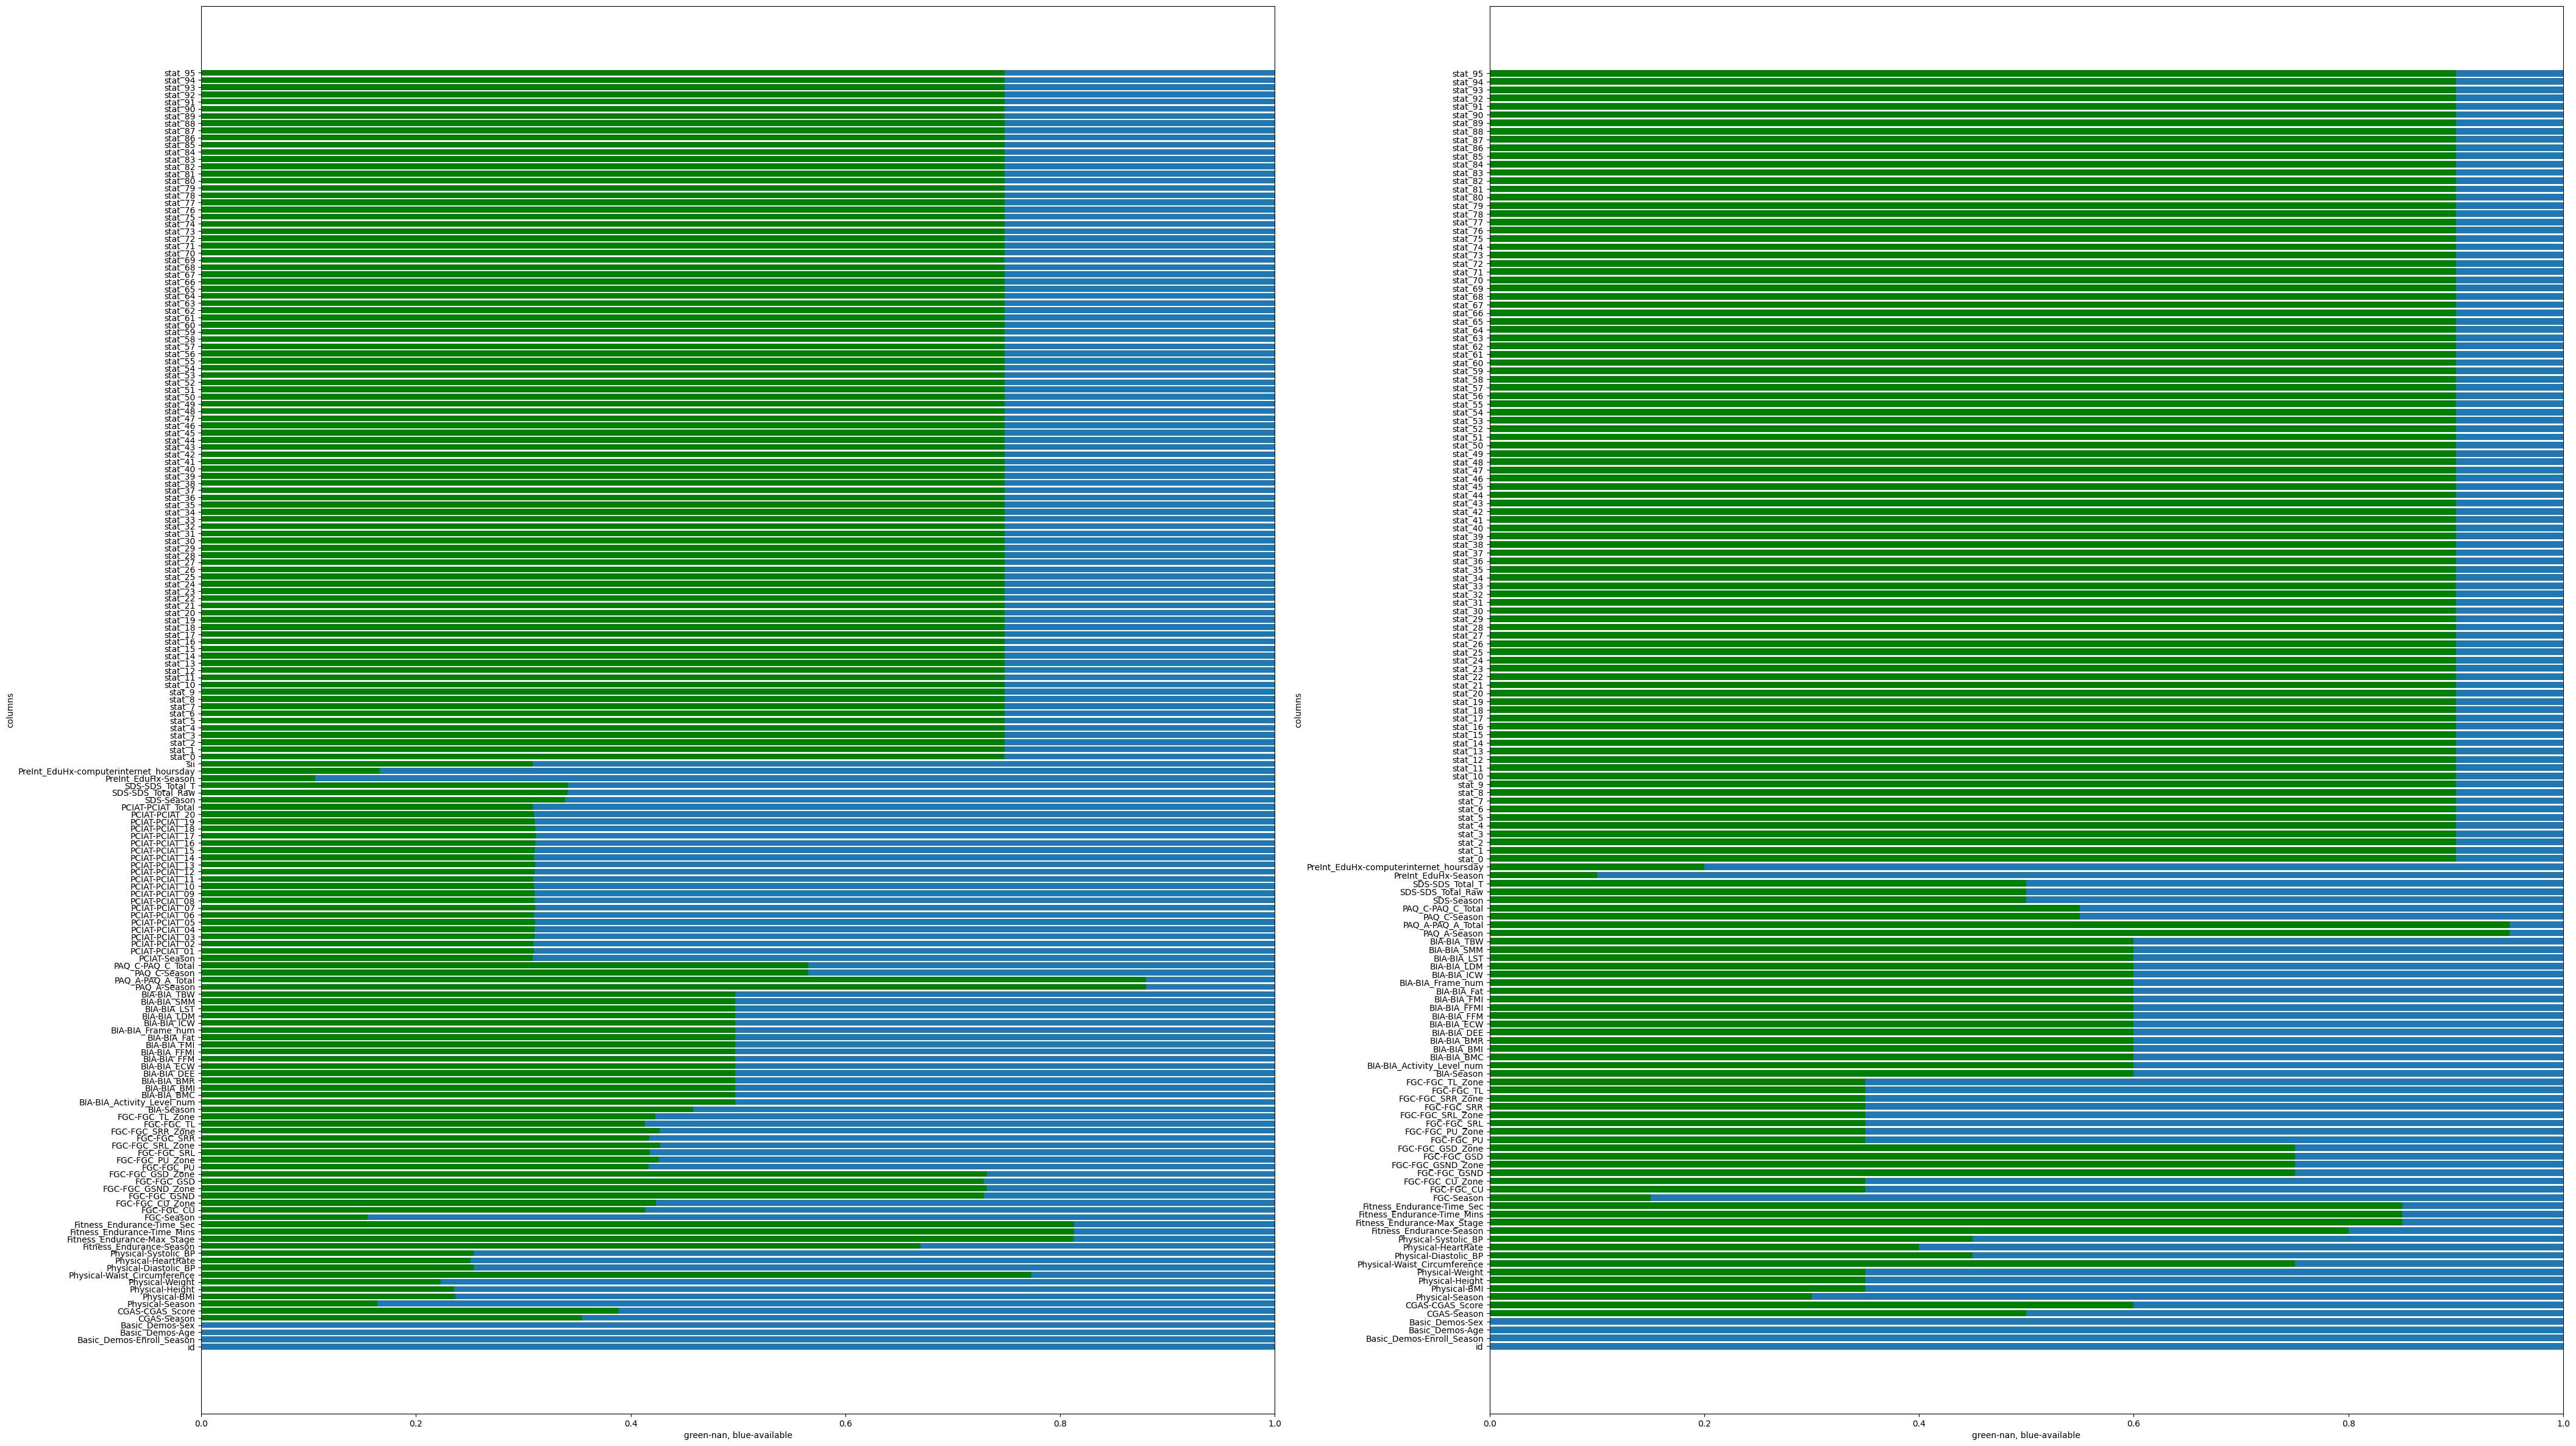

In [78]:
train_nan_count = merge_train_df.isnull().sum()
test_nan_count = merge_test_df.isnull().sum()
nan_train_ratio = train_nan_count / len(merge_train_df)
nan_test_ratio = test_nan_count / len(merge_test_df)
plt.figure(figsize=(50,30))

plt.subplot(1,2,1)
plt.barh(y=merge_train_df.columns, width=nan_train_ratio, color="green")
plt.barh(y=merge_train_df.columns, width=1-nan_train_ratio, left=nan_train_ratio)
plt.xlabel("green-nan, blue-available")
plt.ylabel("columns")
plt.xlim(0,1)


plt.subplot(1,2,2)
plt.barh(y=merge_test_df.columns, width=nan_test_ratio, color="green")
plt.barh(y=merge_test_df.columns, width=1-nan_test_ratio, left=nan_test_ratio)
plt.xlabel("green-nan, blue-available")
plt.ylabel("columns")
plt.xlim(0,1)


In [79]:
drop_columns = merge_train_df.columns.difference(merge_test_df.columns)
drop_columns = drop_columns.drop("sii")
drop_columns 

Index(['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
       'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08',
       'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12',
       'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16',
       'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20',
       'PCIAT-PCIAT_Total', 'PCIAT-Season'],
      dtype='object')

In [80]:
merge_fixed_train_df = merge_train_df.drop(drop_columns, axis=1)
print(merge_fixed_train_df.shape)
print(merge_test_df.shape)

(3960, 156)
(20, 155)


In [81]:
pd.set_option('display.max_columns', None)
merge_fixed_train_df.head(10)

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,192

In [82]:
columns_for_one_hot = ["Basic_Demos-Enroll_Season","CGAS-Season","Physical-Season",
                       "Fitness_Endurance-Season","FGC-Season","BIA-Season",
                       "PAQ_A-Season","PAQ_C-Season","SDS-Season","PreInt_EduHx-Season"]

In [83]:
merge_fixed_train_df

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44

In [84]:
merge_fixed_train_df[columns_for_one_hot] = merge_fixed_train_df[columns_for_one_hot].fillna("unknown")
merge_test_df[columns_for_one_hot] = merge_test_df[columns_for_one_hot].fillna("unknown")

one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded_train = one_hot_encoder.fit_transform(merge_fixed_train_df[columns_for_one_hot])
one_hot_encoded_train_df = pd.DataFrame(one_hot_encoded_train, columns = one_hot_encoder.get_feature_names_out(columns_for_one_hot)).astype(int)
merge_fixed_dropped_train_df = merge_fixed_train_df.drop(columns_for_one_hot, axis=1)
first_encoded_train_df = pd.concat([merge_fixed_dropped_train_df, one_hot_encoded_train_df], axis=1)

one_hot_encoded_test = one_hot_encoder.transform(merge_test_df[columns_for_one_hot])
one_hot_encoded_test_df = pd.DataFrame(one_hot_encoded_test, columns = one_hot_encoder.get_feature_names_out(columns_for_one_hot)).astype(int)
merge_dropped_test_df = merge_test_df.drop(columns_for_one_hot, axis=1)
first_encoded_test_df = pd.concat([merge_dropped_test_df, one_hot_encoded_test_df], axis=1)


print(first_encoded_train_df.shape)
print(first_encoded_test_df.shape)

(3960, 195)
(20, 194)


In [85]:
first_encoded_test_df

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,Basic_Demos-Enroll_Season_Fall,Basic_Demos-Enroll_Season_Spring,Basic_Demos-Enroll_Season_Summer,Basic_Demos-Enroll_Season_Winter,CGAS-Season_Fall,CGAS-Season_Spring,CGAS-Season_Summer,CGAS-Season_Winter,CGAS-Season_unknown,Physical-Season_Fall,Physical-Season_Spring,Physical-Season_Summer,Physical-Season_Winter,Physical-Season_unknown,Fitness_Endurance-Season_Fall,Fitness_Endurance-Season_Spring,Fitness_Endurance-Season_Summer,Fitness_Endurance-Season_Winter,Fitness_Endurance-Season_unknown,FGC-Season_Fall,FGC-Season_Spring,FGC-Season_Summer,FGC-Season_Winter,FGC-Season_unknown,BIA-Season_Fall,BIA-Season_Spring,BIA-Season_Summer,BIA-Season_Winter,BIA-Season_unknown,PAQ_A-Season_Fall,PAQ_A-Season_Spring,PAQ_A-Season_Summer,PAQ_A-Season_Winter,PAQ_A-Season_unknown,PAQ_C-Season_Fall,PAQ_C-Season_Spring,PAQ_C-Season_Summer,PAQ_C-Season_Winter,PAQ_C-Season_unknown,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,SDS-Season_unknown,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter,PreInt_EduHx-Season_unknown
0,00008ff9,5,0,51.0,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
1,000fd460,9,0,NaN,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [86]:
columns_for_ordinal = ["Basic_Demos-Sex","Basic_Demos-Sex","FGC-FGC_CU_Zone","FGC-FGC_GSND_Zone",
                       "FGC-FGC_PU_Zone","FGC-FGC_SRL_Zone","FGC-FGC_SRR_Zone",
                      "FGC-FGC_TL_Zone","BIA-BIA_Activity_Level_num","BIA-BIA_Frame_num",
                      "PreInt_EduHx-computerinternet_hoursday"]

In [87]:
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value= np.nan)
second_encoded_train_df = first_encoded_train_df.copy()
second_encoded_test_df = first_encoded_test_df.copy()
second_encoded_train_df[columns_for_ordinal] = ordinal_encoder.fit_transform(second_encoded_train_df[columns_for_ordinal])
second_encoded_test_df[columns_for_ordinal] = ordinal_encoder.transform(second_encoded_test_df[columns_for_ordinal])
for column in columns_for_ordinal:
    second_encoded_train_df[column] = second_encoded_train_df[column].fillna(-1)
    second_encoded_test_df[column] = second_encoded_test_df[column].fillna(-1)

In [88]:
second_encoded_train_df.shape

(3960, 195)

In [89]:
# normalization
def check_normality(df):
    numerical_columns = list(set(df.columns) - set(columns_for_one_hot) - set(columns_for_ordinal) - set(col for col in df.columns if "Season" in col) -set(["sii", "id"]))
    df[numerical_columns]
    result = {}
    for col in numerical_columns:
        data = df[col].dropna()
        stat1, p1 = shapiro(data)
        stat2, p2 = normaltest(data)
        if p1 > 0.05 and p2 > 0.05:
            result.update({col: True})
        else:
            result.update({col: False})
    return result

In [90]:
result = check_normality(second_encoded_train_df)
normalized_train_df = second_encoded_train_df.copy()
normalized_test_df = second_encoded_test_df.copy()
non_normal_columns = []
for col in result.keys():
    if result[col]==False:
        non_normal_columns.append(col)

minmax = MinMaxScaler()
normalized_train_df[non_normal_columns] = minmax.fit_transform(second_encoded_train_df[non_normal_columns])
normalized_test_df[non_normal_columns] = minmax.transform(second_encoded_test_df[non_normal_columns])
normalized_train_df

/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,Basic_Demos-Enroll_Season_Fall,Basic_Demos-Enroll_Season_Spring,Basic_Demos-Enroll_Season_Summer,Basic_Demos-Enroll_Season_Winter,CGAS-Season_Fall,CGAS-Season_Spring,CGAS-Season_Summer,CGAS-Season_Winter,CGAS-Season_unknown,Physical-Season_Fall,Physical-Season_Spring,Physical-Season_Summer,Physical-Season_Winter,Physical-Season_unknown,Fitness_Endurance-Season_Fall,Fitness_Endurance-Season_Spring,Fitness_Endurance-Season_Summer,Fitness_Endurance-Season_Winter,Fitness_Endurance-Season_unknown,FGC-Season_Fall,FGC-Season_Spring,FGC-Season_Summer,FGC-Season_Winter,FGC-Season_unknown,BIA-Season_Fall,BIA-Season_Spring,BIA-Season_Summer,BIA-Season_Winter,BIA-Season_unknown,PAQ_A-Season_Fall,PAQ_A-Season_Spring,PAQ_A-Season_Summer,PAQ_A-Season_Winter,PAQ_A-Season_unknown,PAQ_C-Season_Fall,PAQ_C-Season_Spring,PAQ_C-Season_Summer,PAQ_C-Season_Winter,PAQ_C-Season_unknown,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,SDS-Season_unknown,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter,PreInt_EduHx-Season_unknown
0,00008ff9,0.000000,0.0,0.026694,0.285417,0.285714,0.161270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,-1.0,NaN,NaN,0.000000,0.0,0.322581,0.0,0.285714,0.0,0.272727,1.0,1.0,0.002536,0.312401,0.001446,0.003385,0.002001,0.001446,0.028360,0.886743,0.983750,0.0,0.004070,0.001372,0.003283,0.004131,0.002134,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
1,000fd460,0.235294,0.0,NaN,0.237360,0.329670,0.146032,0.12500,0.418994,0.387387,0.600985,NaN,NaN,NaN,0.026087,0.0,NaN,-1.0,NaN,NaN,0.098039,0.0,0.506912,1.0,0.523810,1.0,0.136364,0.0,1.0,0.002515,0.259649,0.001497,0.003439,0.001309,0.001497,0.023632,0.878426,0.983161,0.0,0.002679,0.003331,0.003397,0.002985,0.001140,NaN,0.418052,0.367089,0.419355,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [91]:
best_lgb_params = {'learning_rate': 0.03884249148676395, 'max_depth': 12, 'num_leaves': 413, 'min_data_in_leaf': 14,
           'feature_fraction': 0.7987976913702801, 'bagging_fraction': 0.7602261703576205, 'bagging_freq': 2, 
           'lambda_l1': 4.735462555910575, 'lambda_l2': 4.735028557007343e-06}
SEED=42

In [96]:
train = normalized_train_df.dropna(subset=["sii"])
x_train = train.drop(["id", "sii"], axis=1)
id_train = train["id"]
y_train = train["sii"]
id_test = normalized_test_df["id"]
x_test = normalized_test_df.drop(["id"], axis=1)

In [98]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")
def threshhold(y, thresholds):
    return np.where(y < thresholds[0], 0,
                 np.where(y < thresholds[1], 1,
                        np.where(y < thresholds[2], 2, 3)))
def optimization(thresholds, y_true, y_pred):
    y_pred_rounded = threshhold(y_pred, thresholds)
    return -quadratic_weighted_kappa(y_true, y_pred_rounded)
def cross_validation(model, x_test):
    skf = StratifiedKFold(n_splits=5)
    train_S = []
    valid_S = []
    va_kappa = np.zeros(5)
    tr_kappa = np.zeros(5)
    results = np.zeros((len(normalized_test_df), 5))
    oof_non_rounded = np.zeros(len(y_train), dtype=float)
    for fold, (tr_idx, va_idx) in enumerate(tqdm(skf.split(x_train, y_train), desc="Training Fold", total=5)):
        x_tr, x_va = x_train.iloc[tr_idx], x_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
        fit_model = model.fit(x_tr, y_tr)
        save_path = f'/kaggle/working/model_{fold}.joblib'
        joblib.dump(fit_model, save_path)
        y_tr_pred = np.round(fit_model.predict(x_tr)).astype(int)
        y_va_pred = fit_model.predict(x_va)
        oof_non_rounded[va_idx] = y_va_pred
        train_S.append(y_tr_pred)
        valid_S.append(np.round(y_va_pred).astype(int))
        tr_kappa[fold] = quadratic_weighted_kappa(y_tr_pred, y_tr)
        va_kappa[fold] = quadratic_weighted_kappa(np.round(y_va_pred).astype(int), y_va)
        print("{}fold -> train kappa: {:.4f}, valid kappa: {:.4f}".format(fold, tr_kappa[fold], va_kappa[fold]))
        results[:, fold] = np.round(fit_model.predict(x_test), 0)
    print("train kappa mean -> {:.4f}, valid kappa mean -> {:.4f}".format(tr_kappa.mean(), va_kappa.mean()))
    KappaOptimizer = minimize(optimization, x0=[0.5, 1.5, 2.5],args = (y_train, oof_non_rounded), method='Nelder-Mead')
    assert KappaOptimizer.success
    y_optimized_pred = threshhold(oof_non_rounded, KappaOptimizer.x)
    optimized_kappa = quadratic_weighted_kappa(y_train, y_optimized_pred)
    print(f"Optimized_Kappa -> {optimized_kappa}")
    result = results.mean(axis=1)
    tpTune = threshhold(result, KappaOptimizer.x)
    submission= pd.DataFrame({"id":id_test,"sii":tpTune})
    return submission, optimized_kappa

In [99]:
submission,tKappa = cross_validation(lgb.LGBMRegressor(**best_lgb_params, random_state=SEED, n_estimators=200, verbose=-1), x_test)

Training Fold:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

0fold -> train kappa: 0.8284, valid kappa: 0.3614


Training Fold:  40%|████      | 2/5 [00:05<00:08,  2.93s/it]

1fold -> train kappa: 0.8250, valid kappa: 0.4650


Training Fold:  60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

2fold -> train kappa: 0.8215, valid kappa: 0.4036


Training Fold:  80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

3fold -> train kappa: 0.8287, valid kappa: 0.3651


Training Fold: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

4fold -> train kappa: 0.8371, valid kappa: 0.3342
train kappa mean -> 0.8281, valid kappa mean -> 0.3859


Optimized_Kappa -> 0.4505966910061777


In [100]:
submission = pd.DataFrame({'id': id_test,'sii': tpTune})
submission.to_csv("submission.csv", index=False)

In [101]:
submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,1
4,0016bb22,1
5,001f3379,2
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,1
